In [1]:
#-------- Import Libraries --------#
import torch
#import esm
import os
import time
import sys
import random
import pickle
import gc
#import mlflow
import collections
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sn
import matplotlib.pyplot as plt
from datetime import date
from sklearn.metrics import matthews_corrcoef
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F  # All functions that don't have any parameters
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc

In [2]:
#-------- Import Modules from project--------#
#import encoding as enc
from model import Net, Net_thesis, Net_project, Net_project_simple_CNN_RNN, Net_project_transformer_CNN_RNN
import functions as func

### !!!!!!!!  I need to send new functions and encodings files to you, but for now:  
def esm_1b_peptide(peptides, pooling=True):
    embeddings = list()
    # Load pre-trained ESM-1b model

    model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
    batch_converter = alphabet.get_batch_converter()
    data = []
    seq_rep = []   ### NEW
    count = 0
    for peptide in peptides:
        data.append(("", peptide))
    batch_labels, batch_strs, batch_tokens = batch_converter(data)
    with torch.no_grad():
        results = model(batch_tokens, repr_layers=[12], return_contacts=True)
    token_representations = results["representations"][12]
    del results, batch_labels, batch_strs, batch_tokens, model, alphabet, batch_converter
    gc.collect()
    print("results are ready")
    for i, (_, seq) in enumerate(data):
        if pooling:
             seq_rep.append( token_representations[i, 1: len(seq) + 1].mean(0) )   ### NEW
        else:
            seq_rep.append( token_representations[i, 1: len(seq) + 1] )   ### NEW
    del token_representations
    gc.collect()  
    return seq_rep ### NEW

def reverseOneHot(encoding):
    """
    Converts one-hot encoded array back to string sequence
    """
    seq=''
    for i in range(len(encoding)):
            if return_aa(encoding[i].tolist()) != 'X':
                seq+=return_aa(encoding[i].tolist())
    return seq

def extract_sequences(dataset_X, merge=False):
    """
    Return DataFrame with MHC, peptide and TCR a/b sequences from
    one-hot encoded complex sequences in dataset X
    """
    mhc_sequences = [reverseOneHot(arr[0:179,0:20]) for arr in dataset_X]
    pep_sequences = [reverseOneHot(arr[179:192,0:20]) for arr in dataset_X] ## 190 or 192 ????
    tcr_sequences = [reverseOneHot(arr[192:,0:20]) for arr in dataset_X]
    all_sequences = [reverseOneHot(arr[:,0:20]) for arr in dataset_X]

    if merge:
        df_sequences = pd.DataFrame({"all": all_sequences})

    else:
        df_sequences = pd.DataFrame({"MHC":mhc_sequences,
                                 "peptide":pep_sequences,
                                 "TCR":tcr_sequences})
        
    return df_sequences        
    
def extract_sequences(dataset_X, merge=False):
    """
    Return DataFrame with MHC, peptide and TCR a/b sequences from
    one-hot encoded complex sequences in dataset X
    """
    mhc_sequences = [reverseOneHot(arr[0:179,0:20]) for arr in dataset_X]
    pep_sequences = [reverseOneHot(arr[179:192,0:20]) for arr in dataset_X] ## 190 or 192 ????
    tcr_sequences = [reverseOneHot(arr[192:,0:20]) for arr in dataset_X]
    all_sequences = [reverseOneHot(arr[:,0:20]) for arr in dataset_X]

    if merge:
        df_sequences = pd.DataFrame({"all": all_sequences})

    else:
        df_sequences = pd.DataFrame({"MHC":mhc_sequences,
                                 "peptide":pep_sequences,
                                 "TCR":tcr_sequences})
        
    return df_sequences
    

def extract_aa_and_energy_terms(dataset_X):
    new_dataset_X = list()
    for cmplx in range(len(dataset_X)):
        df = pd.DataFrame(dataset_X[cmplx])
        df['aa'] = 'A'
        for i in range(len(df)):
            df['aa'][i] = return_aa(list(df.iloc[i,0:20]))
        df = df.iloc[:,20:]
        new_dataset_X.append(np.array(df))
    return np.array(new_dataset_X)   

def return_aa(one_hot):
    mapping = dict(zip(range(20),"ACDEFGHIKLMNPQRSTVWY"))
    try:
        index = one_hot.index(1)
        return mapping[index]     
    except:
        return 'X'

In [3]:
#-------- Set Device --------#

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
else:
    print('No GPUs available. Using CPU instead.')
    device = torch.device('cpu')

No GPUs available. Using CPU instead.


In [4]:
#-------- Seeds --------#

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

torch.use_deterministic_algorithms(True)

In [5]:
#-------- Directories --------#

DATADIR = '/data/'
TRAINDIR = '../data/train'
VALIDATIONDIR = '../data/validation'
MATRICES = '/data/Matrices'


In [6]:
#-------- Unzip Train --------#

try:
    if len(os.listdir(TRAINDIR)) != 0:
        print("{} already unzipped.".format(TRAINDIR))
except:
    !unzip ../data/train.zip -d ../data/train

    
#-------- Unzip Validation --------#

try:
    if len(os.listdir(VALIDATIONDIR)) != 0:
        print("{} already unzipped.".format(VALIDATIONDIR))
except:
    !unzip ../data/validation.zip -d ../data/validation
    
print('Train directory:\n\n', '\n'.join(str(p) for p in os.listdir(TRAINDIR)), '\n\n')
print('Validation directory:\n\n','\n'.join(str(p) for p in os.listdir(VALIDATIONDIR)))

../data/train already unzipped.
../data/validation already unzipped.
Train directory:

 P2_labels.npz
P3_input.npz
P4_input.npz
P2_input.npz
__MACOSX
P1_input.npz
P3_labels.npz
P4_labels.npz
P1_labels.npz 


Validation directory:

 P5_input.npz
P5_labels.npz
__MACOSX


In [7]:
#-------- Import Dataset --------#

data_list = []
target_list = []

import glob
for fp in glob.glob("../data/train/*input.npz"):
    data = np.load(fp)["arr_0"]
    targets = np.load(fp.replace("input", "labels"))["arr_0"]
    data_list.append(data)
    target_list.append(targets)
    
for fp in glob.glob("../data/validation/*input.npz"):
    data = np.load(fp)["arr_0"]
    targets = np.load(fp.replace("input", "labels"))["arr_0"]
    data_list.append(data)
    target_list.append(targets)
    
data_partitions = len(data_list)

print("Number of files:", data_partitions)

for i in range(data_partitions):
    print("Size of file", i, len(data_list[i]))

Number of files: 5
Size of file 0 1480
Size of file 1 1532
Size of file 2 1168
Size of file 3 1526
Size of file 4 1207


In [8]:
for i in range(len(target_list)):
    print("File:", i)
    frequency = collections.Counter(target_list[i])
    print(dict(frequency), "\n")

File: 0
{1.0: 370, 0.0: 1110} 

File: 1
{1.0: 383, 0.0: 1149} 

File: 2
{1.0: 292, 0.0: 876} 

File: 3
{1.0: 380, 0.0: 1146} 

File: 4
{1.0: 301, 0.0: 906} 



In [9]:
cross_validation = False
merge = True


In [10]:
#-------- Hyperparameters to fine tune -------#
embedding = "baseline" #esm-1b
numHN=64
numFilter=100
dropOutRate=0.1
keep_energy=True

In [11]:
#-------- Encode ALL --------#

if "embedding" == 'esm-1b':
    
    if merge == True:
    
        start = time.time()

        count=0

        embedding_dir= '../data/embeddedFiles/'

        data_list_new = list()

        batch = 5 #### DEBUGGED

        print("batch:", batch)

        for dataset in data_list[:-1]: ## last file

            dataset = dataset
            count += 1

            print("\nWorking on file", count, "- size:", len(dataset))
            encoded = list()

            print("Merge true")
            x_enc = extract_sequences(dataset, merge=True)
            print("Sequences are extracted")
            print("Start encoding\n")
            for i in range(0, len( x_enc['all'].tolist() ), batch):
                if i % batch == 0:
                    print("Flag:", i, "peptides are encoded - Time:", round(time.time()-start,2))
                all_i = esm_1b_peptide( x_enc['all'].tolist()[i : i + batch] , pooling=False) #### DEBUGGED (batch = any number you wanna pass at once, that your pc can handle)
                encoded.extend(all_i) 

            data_list_new.append(encoded)

            print("Encoding is done - encoded size:", len(encoded))
            print("Save in file")
            outfile = open(embedding_dir + 'dataset-all-{}-file{}'.format("esm1b", count), 'wb')
            pickle.dump(encoded, outfile)
            outfile.close()
            print("Saving is done.\n\n")
else:
    print('baseline')
    data_list_enc = data_list

baseline


In [12]:
#-------- Paste Energy Terms Next to it --------#  ########### !!! May require debugging
'''
if embedding == "esm-1b":
    if merge == True:
        data_list_enc = list()

        for t in range(len(data_list)):
            print(t)
            data_list_t = list()
            for cmplx in range(len(data_list[t])):

                df = pd.DataFrame( data_list[t][cmplx] ) #### baseline data to extract enery 
                x_df = pd.DataFrame( extract_aa_and_energy_terms(data_list[t])[cmplx] ) #### baseline data to find all 0s (paddings) 
                embedding_complex = pd.DataFrame(data_list_new[t][cmplx]) ##### new embeded data

                pad_index_list = sorted(x_df[x_df.iloc[:,34]=='X'].index.tolist())

                padding1_len = 0
                for pad in range(len(pad_index_list)):
                    padding1_len += 1
                    if pad_index_list[pad+1]-pad_index_list[pad] > 100:
                        tcr_start = pad_index_list[pad] + 1
                        tcr_end = pad_index_list[pad+1]
                        break
                padding2_len = len(pad_index_list) - padding1_len

                mhc = pd.concat([df.iloc[:179,20:].reset_index(drop=True), ///embedding_complex[??] here put mhc part of your embedding -> 0:179/// ], axis=1).iloc[:, :-1].reset_index(drop=True)
                pep = pd.concat([df.iloc[179:188,20:].reset_index(drop=True), ///embedding_complex[??] peptide part of your embedding -> 179:179+9/// ], axis=1).iloc[:, :-1].reset_index(drop=True)
                tcr = pd.concat([(df.iloc[tcr_start:tcr_end,20:]).reset_index(drop=True), ///embedding_complex[??] tcr partofyourembedding -> tcrstart: tcrend/// ], axis=1).iloc[:, :-1].reset_index(drop=True)
                padding = pd.DataFrame(0, index=np.arange(padding1_len + padding2_len), columns=pep.columns)

                final_cmplx = pd.concat([mhc,pep,tcr,padding]).reset_index(drop=True)
                final_cmplx.columns = np.arange(len(final_cmplx.columns))
                data_list_t.append(np.array(final_cmplx))

            data_list_enc.append(np.array(data_list_t))
            
'''

'\nif embedding == "esm-1b":\n    if merge == True:\n        data_list_enc = list()\n\n        for t in range(len(data_list)):\n            print(t)\n            data_list_t = list()\n            for cmplx in range(len(data_list[t])):\n\n                df = pd.DataFrame( data_list[t][cmplx] ) #### baseline data to extract enery \n                x_df = pd.DataFrame( extract_aa_and_energy_terms(data_list[t])[cmplx] ) #### baseline data to find all 0s (paddings) \n                embedding_complex = pd.DataFrame(data_list_new[t][cmplx]) ##### new embeded data\n\n                pad_index_list = sorted(x_df[x_df.iloc[:,34]==\'X\'].index.tolist())\n\n                padding1_len = 0\n                for pad in range(len(pad_index_list)):\n                    padding1_len += 1\n                    if pad_index_list[pad+1]-pad_index_list[pad] > 100:\n                        tcr_start = pad_index_list[pad] + 1\n                        tcr_end = pad_index_list[pad+1]\n                        

In [13]:
if embedding == "esm-1b":
    print(final_cmplx.to_markdown()) 

In [14]:
if embedding == "baseline":
    print("baseline")
    print(len(data_list_enc), "\n")

    for i in range(len(data_list)):
        print("number of complexes:", len(data_list[i]))
        print("number of rows:", len(data_list[i][0]))
        print("number of columns:", len(data_list[i][0][0]))
        print("\n")

else:
    print("ESM 1B:")
    final_cmplx

    print(len(data_list_enc), "\n")

    for i in range(len(data_list_enc)):
        print("number of complexes:", len(data_list_enc[i]))
        print("number of rows:", len(data_list_enc[i][0]))
        print("number of columns:", len(data_list_enc[i][0][0]))
        print("\n")
    


baseline
5 

number of complexes: 1480
number of rows: 420
number of columns: 54


number of complexes: 1532
number of rows: 420
number of columns: 54


number of complexes: 1168
number of rows: 420
number of columns: 54


number of complexes: 1526
number of rows: 420
number of columns: 54


number of complexes: 1207
number of rows: 420
number of columns: 54




In [15]:
#fixed hyperparameters
num_classes = 1
learning_rate = 0.001
bat_size = 128
epochs = 100
patience = epochs // 10
criterion = nn.BCEWithLogitsLoss()

In [16]:
X_train = np.concatenate(data_list_enc[0:3])
y_train = np.concatenate(target_list[0:3])
nsamples, nx, ny = X_train.shape
print("Training set shape:", nsamples,nx,ny)

X_valid = np.concatenate(data_list_enc[3:4])
y_valid = np.concatenate(target_list[3:4])
nsamples, nx, ny = X_valid.shape
print("Validation set shape:", nsamples,nx,ny)

X_test = np.concatenate(data_list_enc[4:5])
y_test = np.concatenate(target_list[4:5])
nsamples, nx, ny = X_test.shape
print("Test set shape:", nsamples,nx,ny)

# features and residues
features = list(range(ny))
residues = list(range(nx)) 
n_features = len(features)
input_size = len(residues)

# Dataloader
train_ds = []
for i in range(len(X_train)):
    train_ds.append([np.transpose(X_train[i][:,features]), y_train[i]])
    
val_ds = []
for i in range(len(X_valid)):
    val_ds.append([np.transpose(X_valid[i][:,features]), y_valid[i]])
    
test_ds = []
for i in range(len(X_test)):
    test_ds.append([np.transpose(X_test[i][:,features]), y_test[i]])
    
    
train_ldr = torch.utils.data.DataLoader(train_ds,batch_size=bat_size, shuffle=True)
val_ldr = torch.utils.data.DataLoader(val_ds,batch_size=bat_size, shuffle=True)
test_ldr = torch.utils.data.DataLoader(test_ds,batch_size=len(test_ds), shuffle=True) ## Test at once

Training set shape: 4180 420 54
Validation set shape: 1526 420 54
Test set shape: 1207 420 54


In [17]:
###############################
###    CNN+RNN (thesis)     ###
###############################
start = time.time()

if cross_validation == False:
    
    print("Parameters:")
    print("cross_validation", cross_validation)
    print("merge", merge)
    print("embedding", embedding)
    print("numHN", numHN)
    print("numFilter", numFilter)
    print("dropOutRate", dropOutRate)
    print("keep_energy", keep_energy)
    print("num_classes", num_classes)
    print("learning_rate", learning_rate)
    print("bat_size", bat_size)
    print("patience", patience)
    print("criterion", criterion)
    print("\n\n")
    
    #-------- Train --------#

    print("Train")
    # Dataloader
    train_ds = []
    for i in range(len(X_train)):
        train_ds.append([np.transpose(X_train[i][:,features]), y_train[i]])
    val_ds = []
    for i in range(len(X_valid)):
        val_ds.append([np.transpose(X_valid[i][:,features]), y_valid[i]])
    train_ldr = torch.utils.data.DataLoader(train_ds,batch_size=len(train_ds), shuffle=True)
    val_ldr = torch.utils.data.DataLoader(val_ds,batch_size=bat_size, shuffle=True)

    # Initialize network
    net = Net_project_simple_CNN_RNN(num_classes=num_classes, 
             n_features=n_features, 
             numHN=numHN, 
             numFilter=numFilter,
             dropOutRate=dropOutRate).to(device)
    
    optimizer = optim.Adam(net.parameters(), lr=learning_rate,
                           weight_decay=0.0005,
                           amsgrad=True,)
    
    train_acc, train_losses, train_auc, valid_acc, valid_losses, valid_auc, val_preds, val_targs, test_preds, test_targs, test_loss, test_acc, test_auc = func.train_project(net, optimizer, train_ldr, val_ldr, test_ldr, X_valid, epochs, criterion, patience)

else:
    pass

print("Done in", round((time.time()-start)/60,2), "mins." )

print("test_loss, test_acc, test_auc:")
print(test_loss.item(), ",", test_acc[0], ",", test_auc[0])


Parameters:
cross_validation False
merge True
embedding baseline
numHN 64
numFilter 100
dropOutRate 0.1
keep_energy True
num_classes 1
learning_rate 0.001
bat_size 128
patience 5
criterion BCEWithLogitsLoss()



Train
Epoch 0  	 Train loss: 0.00016 	 Validation loss: 0.00518
Epoch 10  	 Train loss: 0.00013 	 Validation loss: 0.00438
Epoch 20  	 Train loss: 0.00012 	 Validation loss: 0.00405
Epoch 30  	 Train loss: 0.00011 	 Validation loss: 0.00377
Epoch 40  	 Train loss: 0.00010 	 Validation loss: 0.00354
Epoch 50  	 Train loss: 0.00009 	 Validation loss: 0.00339
Epoch 60  	 Train loss: 0.00008 	 Validation loss: 0.00324
Early stopping

0
test_loss, test_acc, test_auc:
0.47714927792549133 , 0.8210439105219552 , 0.6988771790866354


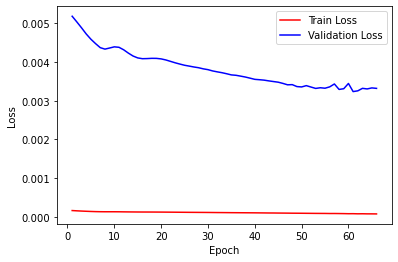

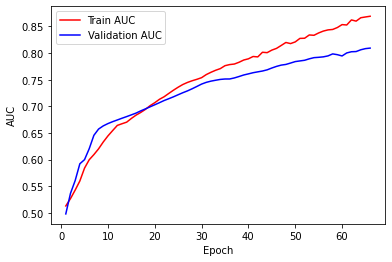

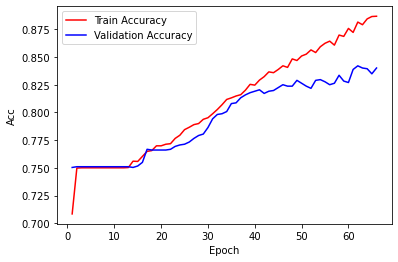

AUC:  0.6988771790866354
MCC:  0.4735409078625545


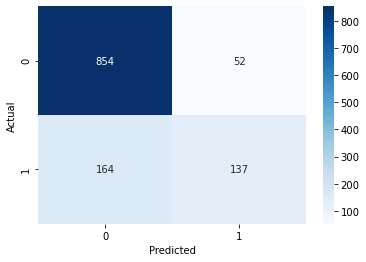

AUC: 0.699
216


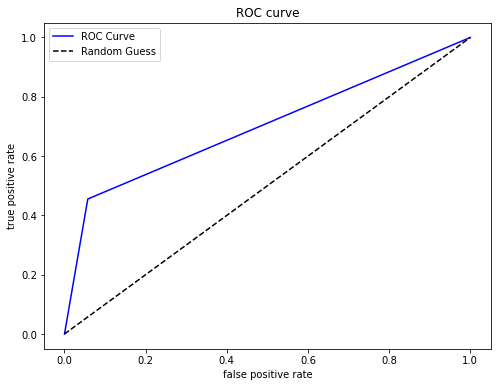

AUC:  0.6988771790866354
MCC:  0.4735409078625545


In [18]:
#-------- Performance --------#

epoch = np.arange(1,len(train_losses)+1)
plt.figure()
plt.plot(epoch, train_losses, 'r', epoch, valid_losses, 'b')
plt.legend(['Train Loss','Validation Loss'])
plt.xlabel('Epoch'), plt.ylabel('Loss')

epoch = np.arange(1,len(train_auc)+1)
plt.figure()
plt.plot(epoch, train_auc, 'r', epoch, valid_auc, 'b')
plt.legend(['Train AUC','Validation AUC'])
plt.xlabel('Epoch'), plt.ylabel('AUC')

epoch = np.arange(1,len(train_acc)+1)
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accuracy','Validation Accuracy'])
plt.xlabel('Epoch'), plt.ylabel('Acc')
plt.show()


#-------- Save results --------#

results = pd.DataFrame(list(zip( (int(x) for x in test_targs), (int(x) for x in test_preds))),columns =['target', 'pred'])
#print(results)

#results.to_csv('results/df_targets_preds_th.csv'.format(str(date.today())), index=False)


#-------- Performance Evaluation --------#
# The results change every time we train, we should check why (maybe we missed something or did wrong with the seeds?)

print("AUC: ", roc_auc_score(results['target'], results['pred']))
print("MCC: ", matthews_corrcoef(results['target'], results['pred']))

confusion_matrix = pd.crosstab(results['target'], results['pred'], rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
plt.show()

# Plot roc curve

fpr, tpr, thres = roc_curve(results['target'], results['pred'])
print('AUC: {:.3f}'.format(roc_auc_score(results['target'], results['pred'])))

print( len([i for i, (a, b) in enumerate(zip(results['pred'], results['target'])) if a != b]))

plt.figure(figsize=(8,6))

# roc curve
plt.plot(fpr, tpr, "b", label='ROC Curve')
plt.plot([0,1],[0,1], "k--", label='Random Guess')
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="best")
plt.title("ROC curve")

plt.show()

AUC = roc_auc_score(results['target'], results['pred'])
MCC = matthews_corrcoef(results['target'], results['pred'])
print("AUC: ", AUC)
print("MCC: ", MCC)

In [19]:
'''
#storing values
with mlflow.start_run():
    mlflow.log_param('embedding', embedding) 
    mlflow.log_param('Hidden Neurons', numHN)
    mlflow.log_param('filters CNN', numFilter)
    mlflow.log_param('Dropout rate', dropOutRate)
    mlflow.log_metric('AUC', AUC)
    mlflow.log_metric('MCC', MCC)
    #ADD ARTIFACTS (PLOTS)
    
'''

"\n#storing values\nwith mlflow.start_run():\n    mlflow.log_param('embedding', embedding) \n    mlflow.log_param('Hidden Neurons', numHN)\n    mlflow.log_param('filters CNN', numFilter)\n    mlflow.log_param('Dropout rate', dropOutRate)\n    mlflow.log_metric('AUC', AUC)\n    mlflow.log_metric('MCC', MCC)\n    #ADD ARTIFACTS (PLOTS)\n    \n"